<a href="https://colab.research.google.com/github/TruongGiangVu/VGG16_RNN_LSTM_SignLanguageRecognition/blob/main/CM_VGG16_LSTM_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
!pip uninstall tensorflow
!pip install --no-cache-dir tensorflow==2.2.0

Uninstalling tensorflow-2.4.1:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.4.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.4.1
     |████████████████████████████████| 516.2MB 1.5MB/s 
     |████████████████████████████████| 460kB 28.7MB/s 
     |████████████████████████████████| 3.0MB 39.4MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# common library 
import numpy as np
import os
import time
import cv2
import matplotlib.pyplot as plt
import glob
from google.colab.patches import cv2_imshow

# tensorflow library
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D, MaxPooling2D
# from keras.layers import TimeDistributed, GRU, Dense, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

from keras.applications.vgg16 import VGG16

# reading data
import csv
import threading

# Label encoder
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [ ]:
# change path
import os
os.chdir('/content/drive/MyDrive/VSLProject')
print(os.getcwd())

/content/drive/MyDrive/VSLProject


# Global params

In [ ]:
# some global params
SIZE = (64, 64) 

# SIZE = (224, 224) 
CHANNELS = 3
NBFRAME = 10
BS = 20

NUM_THREADS = 8

#preprocessing
LENGTH_TRIM = 130
classes_file = 'classes.npy'

#Funtion

## Preprocessing

In [ ]:
# resize image by dsize = (128, 128)
def resizeImage(img, dsize):
  sizeImg = (img.shape[0],img.shape[1])
  if sizeImg != dsize and dsize != (None, None):
    img = cv2.resize(img,dsize)
  return img

# remove left right background
def removeTrimBackground(img, length = 120):
  img = img[:,length:-1*length]
  return img

def resizeScale(img, scale = 30):
  scale_percent = scale # percent of original size
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)
    
  # resize image
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  return resized
  
def preprocessingImg(img, dsize = (128,128)):
  # img = human_detection(img)
  img = removeTrimBackground(img, LENGTH_TRIM)
  img = resizeImage(img, dsize)
  return img

## Video to frame

In [ ]:
class MyVideo:
  def __init__(self, path='', root_path=''):
    self.path = path
    self.root = root_path
    self.video = cv2.VideoCapture(path)
    self.name = path.split("/")[-1]
    self.label = path.split("/")[-2]
  def getVideo(self):
    return self.video
  def getFullPath(self):
    return self.root + '/' + self.path
  def getFileName(self):
    return self.name
  def getFrameCount(self):
    return int(self.video.get(cv2.CAP_PROP_FRAME_COUNT))
  def getLabel(self):
    return self.label
  def release(self):
    self.video.release()
    del self


def videotoframe(myVideo, dsize=(128,128) , numframe=5, start=0, stop=0):
  listframe = []
  length = myVideo.getFrameCount()

  currentFrame = -1
  skipframe = int((length - start - stop)/numframe)
  takeframe = skipframe + start
  taken = 0
  # print('video',video,'length', length, 'skip', skipframe)
  video = myVideo.getVideo()
  while(True):
      # Capture frame-by-frame
      ret, frame = video.read()
      currentFrame += 1

      if ret == False:
          break
      if currentFrame < takeframe:
          continue
      if taken >= numframe:
          break
      frame = resizeScale(frame)
      frame = removeTrimBackground(frame, LENGTH_TRIM)
      frame = resizeImage(frame, dsize)
      listframe.append(frame)

      takeframe += skipframe
      taken += 1
  # When everything done, release the capture
  myVideo.release()
  cv2.destroyAllWindows()
  return listframe

def preprocessingVideo(myVideo):
  frames = videotoframe(myVideo, SIZE, NBFRAME, 10, 30)
  frames = np.array(frames)
  frames = frames / 255.
  return frames

def predictOneVideo(video, classes):
  # preprocessing video path
  if type(video) is not MyVideo:
    video = MyVideo(video)
  item = preprocessingVideo(video)
  item = item[None,:]  # [640,10,64,64,3]
  try:
    # a = model.predict_classes(item) # old version
    predicted = np.argmax(model.predict(item), axis=-1) # [10] [15,12]
    return classes[predicted[0]]  # [16] accept
  except: 
    print('Video', myVideo.name,'has error')
    return 'Null'
  # print(predicted)

def preparePath(path, csv_file = ''):
  paths = []
  if csv_file == '':
    videos = os.listdir(path)
    for video in videos:
        video_path = os.path.join(path, video)
        paths.append(video_path)
  else:
    with open(csv_file) as csvfile: # read path from csv
      reader = csv.reader(csvfile)
      for row in reader:
        video_path = os.path.join(path, row[0])
        paths.append(video_path)

  print(len(paths))
  return paths

## Predict video

In [ ]:
def predictVideoOneTime(paths, classes, verbose = 0):
  data = []
  names = []
  expecteds = []
  n = len(videos)
  for path in paths:
    myVideo = MyVideo(path)
    item = preprocessingVideo(myVideo)
    data.append(item)
    names.append(myVideo.getFileName())
    expecteds.append(myVideo.getLabel())

  data = np.array(data)
  # print(data.shape)
  predicted = np.argmax(model.predict(data), axis=-1)
  # print(predicted)
  # print(classes[predicted])
  dic = {}
  count = 0
  for i in range(n):
    expected = expecteds[i]
    text = 'Video: '+ names[i] + ' Expected: '+ expected + ' Predicted: '+ classes[predicted[i]]
    if expected not in dic:
      dic[expected] = 0
    if expected == classes[predicted[i]]:
      count = count + 1
      dic[expected] = dic[expected] + 1
    else:
      text = '\x1b[31m'+ text + '\x1b[0m'
    
    if verbose == 1 : 
      print(text)
  print()
  print('Accuray:',str(count)+'/'+str(n), ',',str(count/n))
  return dic

def predictVideoOneByOne(paths, classes, verbose = 0):
  dic = {}

  count = 0
  n = len(paths)
  index = 1
  for video in paths:
    myVideo = MyVideo(video)
    predicted = predictOneVideo( myVideo, classes)
    expected = myVideo.getLabel()
    print(index, end=' ')
    text = 'Video: '+ myVideo.getFileName() + ' Expected: '+  expected + ' Predicted: '+ predicted
    if expected not in dic:
      dic[expected] = 0
    if expected == predicted:
      count = count + 1
      dic[expected] = dic[expected] + 1
    else:
      text = '\x1b[31m'+ text + '\x1b[0m'
    index = index + 1
    
    if verbose == 1 : 
      print(text)
    
  print()
  print('Accuray:',str(count)+'/'+str(n), ',',str(count/n))
  return dic

def predictVideoOneByOneReturn2dDict(paths, classes, verbose = 0):
  dic = {}    # to make a confusion maxtrix, im use a 2D dictionary
  count = 0
  n = len(paths)
  index = 0
  for video in paths:
    myVideo = MyVideo(video)
    predicted = predictOneVideo( myVideo, classes)
    expected = myVideo.getLabel()
    print(index+1, end=' ')
    text = 'Video: '+ myVideo.getFileName() + ' Expected: '+  expected + ' Predicted: '+ predicted
    if expected not in dic:
      dic[expected] = dict()
    if predicted not in dic[expected]:
      dic[expected][predicted] = 0
    if expected == predicted:
      count = count + 1
      # dic[expected] = dic[expected] + 1
    else:
      text = '\x1b[31m'+ text + '\x1b[0m'
    
    # process onfusion matrix array
    dic[expected][predicted] += 1


    index = index + 1
    if verbose == 1 : 
      print(text)
    
  print()
  print('Accuray:',str(count)+'/'+str(n), ',',str(count/n))
  return dic

def predictVideo(path, csv_file, classes, verbose = 0 ,isOneTime = False):
  paths = preparePath(path, csv_file)
  
  if isOneTime == True:
    dic = predictVideoOneTime(paths, classes, verbose)
  else:
    dic = predictVideoOneByOneReturn2dDict(paths, classes, verbose)
  return dic

# Model

In [ ]:
def load_VGG16_model(shape=(112, 112, 3)):
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=shape)
  print("Model loaded..!")
  base_model.summary()

  # model.add(Flatten())
  output1 = GlobalMaxPool2D()
  output2 = Flatten()
  module = keras.Sequential([base_model, output1, output2])
  module.summary()
  return module

def LSTMModel(shape=(5, 112, 112, 3), nbout=3):
  model = Sequential()
  convnet = load_VGG16_model(shape[1:])
  # convnet = VGG16_small(shape[1:])
  model.add(TimeDistributed(convnet, input_shape=shape))

  model.add(LSTM(256, dropout=0.2))
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(nbout, activation='softmax'))
  sgd = keras.optimizers.SGD(lr=0.00005, decay = 1e-6, momentum=0.9, nesterov=True)
  # sgd = keras.optimizers.SGD( momentum=0.9, nesterov=True)
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

# Main

In [ ]:
# read classes from file
classes_file = 'classes.npy'
encoder = LabelEncoder()
encoder.classes_ = np.load(classes_file)
classes = np.array(encoder.classes_)
num_classes = len(classes)
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (2560, 5, 112, 112, 3)
print(classes)
# print(INSHAPE) 
model = LSTMModel(INSHAPE, num_classes)
model.load_weights('chkp/weights-LSTM-095625-08_05.hdf5')

print(num_classes,classes)

['Accept' 'Appear' 'Argentina' 'Away' 'Barbecue' 'Bathe' 'Birthday'
 'Bitter' 'Born' 'Breakfast' 'Bright' 'Buy' 'Call' 'Candy' 'Catch'
 'Chewing-gum' 'Coin' 'Colors' 'Copy' 'Country' 'Dance' 'Deaf' 'Drawer'
 'Enemy' 'Find' 'Food' 'Give' 'Green' 'Help' 'Hungry' 'Last name' 'Learn'
 'Light-blue' 'Man' 'Map' 'Milk' 'Mock' 'Music' 'Name' 'None' 'Opaque'
 'Patience' 'Perfume' 'Photo' 'Realize' 'Red' 'Red_2' 'Rice' 'Run' 'Ship'
 'Shut down' 'Skimmer' 'Son' 'Spaghetti' 'Sweet milk' 'Thanks' 'To land'
 'Trap' 'Uruguay' 'Water' 'Where' 'Women' 'Yellow' 'Yogurt']
58892288/58889256 [==============================] - 1s 0us/step
Model loaded..!
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
______________

In [ ]:
start = time.time()

res = predictVideo(
    path='Datasets/lsa64_split/test', 
    csv_file='Datasets/lsa64_videoperfolder/test.csv', 
    classes=classes,
    verbose=1,
    isOneTime = False)

end = time.time()
print('time:', end - start)

640
1 Video: 049_001_005.mp4 Expected: Yogurt Predicted: Yogurt
2 Video: 049_002_005.mp4 Expected: Yogurt Predicted: Yogurt
3 Video: 049_003_005.mp4 Expected: Yogurt Predicted: Yogurt
4 Video: 049_004_005.mp4 Expected: Yogurt Predicted: Yogurt
5 Video: 049_005_005.mp4 Expected: Yogurt Predicted: Yogurt
6 Video: 049_006_005.mp4 Expected: Yogurt Predicted: Yogurt
7 Video: 049_007_005.mp4 Expected: Yogurt Predicted: Yogurt
8 Video: 049_008_005.mp4 Expected: Yogurt Predicted: Yogurt
9 Video: 049_009_005.mp4 Expected: Yogurt Predicted: Yogurt
10 Video: 049_010_005.mp4 Expected: Yogurt Predicted: Yogurt
11 Video: 009_001_005.mp4 Expected: Women Predicted: Women
12 Video: 009_002_005.mp4 Expected: Women Predicted: Women
13 Video: 009_003_005.mp4 Expected: Women Predicted: Women
14 Video: 009_004_005.mp4 Expected: Women Predicted: Women
15 Video: 009_005_005.mp4 Expected: Women Predicted: Women
16 Video: 009_006_005.mp4 Expected: Women Predicted: Women
17 Video: 009_007_005.mp4 Expected: Women

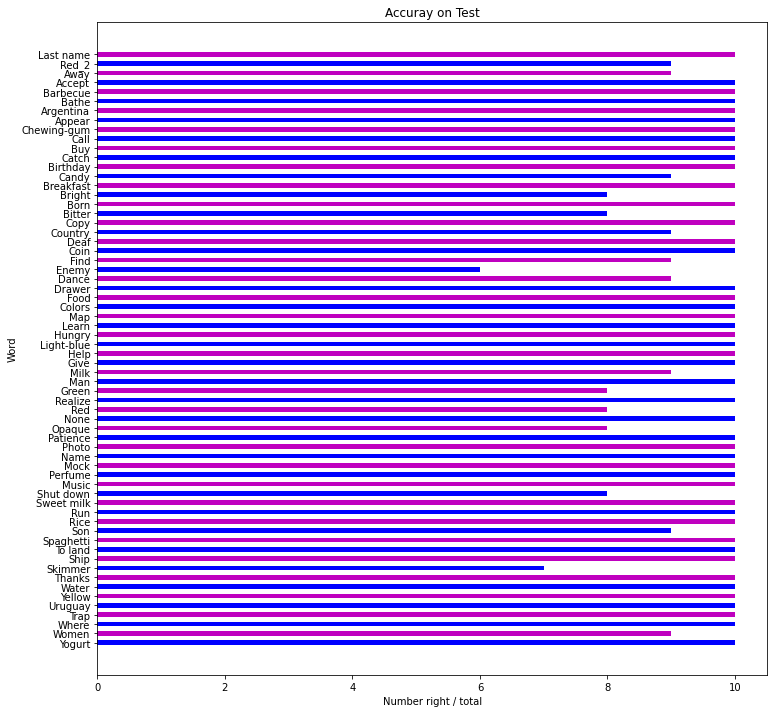

In [ ]:
sorted(res)
ticks=range(len(res))
# nếu phần code tiếp theo bị lỗi là do đang sử dụng hàm predictOneByOneReturn2dDict nha
height=list(res.values())
tick_label=list(res.keys())

fig = plt.figure(figsize=(12, 12))
plt.barh(ticks,height,tick_label=tick_label,color=['b','m'],height=0.5, align='center')
plt.title("Accuray on Test")
plt.ylabel("Word")
plt.xlabel("Number right / total")
plt.show()

In [ ]:
a = np.array(list(res.values()))
print(a)
print(list(res.keys()))

[{'Yogurt': 10} {'Women': 9, 'Drawer': 1} {'Where': 10} {'Trap': 10}
 {'Uruguay': 10} {'Yellow': 10} {'Water': 10} {'Thanks': 10}
 {'Bright': 2, 'Milk': 1, 'Skimmer': 7} {'Ship': 10} {'To land': 10}
 {'Spaghetti': 10} {'Son': 9, 'Light-blue': 1} {'Rice': 10} {'Run': 10}
 {'Sweet milk': 10} {'Shut down': 8, 'Uruguay': 1, 'Deaf': 1}
 {'Music': 10} {'Perfume': 10} {'Mock': 10} {'Name': 10} {'Photo': 10}
 {'Patience': 10} {'Opaque': 8, 'Bright': 1, 'Away': 1} {'None': 10}
 {'Red': 8, 'Green': 2} {'Realize': 10} {'Green': 8, 'Red': 2} {'Man': 10}
 {'Milk': 9, 'Skimmer': 1} {'Give': 10} {'Help': 10} {'Light-blue': 10}
 {'Hungry': 10} {'Learn': 10} {'Map': 10} {'Colors': 10} {'Food': 10}
 {'Drawer': 10} {'Dance': 9, 'Appear': 1}
 {'Enemy': 6, 'Drawer': 1, 'Opaque': 1, 'Skimmer': 1, 'Red_2': 1}
 {'Find': 9, 'Hungry': 1} {'Coin': 10} {'Deaf': 10}
 {'Country': 9, 'Deaf': 1} {'Copy': 10}
 {'Bitter': 8, 'Opaque': 1, 'Bright': 1} {'Born': 10}
 {'Bright': 8, 'Away': 1, 'Skimmer': 1} {'Breakfast': 10

In [ ]:
# exchange result dict to confusion array
a = np.zeros((64,64), dtype=int)
a_true = list(res.keys())
a_pred = list(res.keys())
print(a_true)

matrix = list(res.values())
for w_class in a_true:
  for word in list(res[w_class]):
    a[a_true.index(w_class)][a_true.index(word)] = res[w_class][word]

print(a)

['Yogurt', 'Women', 'Where', 'Trap', 'Uruguay', 'Yellow', 'Water', 'Thanks', 'Skimmer', 'Ship', 'To land', 'Spaghetti', 'Son', 'Rice', 'Run', 'Sweet milk', 'Shut down', 'Music', 'Perfume', 'Mock', 'Name', 'Photo', 'Patience', 'Opaque', 'None', 'Red', 'Realize', 'Green', 'Man', 'Milk', 'Give', 'Help', 'Light-blue', 'Hungry', 'Learn', 'Map', 'Colors', 'Food', 'Drawer', 'Dance', 'Enemy', 'Find', 'Coin', 'Deaf', 'Country', 'Copy', 'Bitter', 'Born', 'Bright', 'Breakfast', 'Candy', 'Birthday', 'Catch', 'Buy', 'Call', 'Chewing-gum', 'Appear', 'Argentina', 'Bathe', 'Barbecue', 'Accept', 'Away', 'Red_2', 'Last name']
[[10  0  0 ...  0  0  0]
 [ 0  9  0 ...  0  0  0]
 [ 0  0 10 ...  0  0  0]
 ...
 [ 0  0  0 ...  9  0  0]
 [ 0  1  0 ...  0  9  0]
 [ 0  0  0 ...  0  0 10]]


In [ ]:
# remove class with 100% predicted from confusion array
i=0
while i < (np.shape(a)[0]):
    c_true = 0
    for j in range(np.shape(a)[1]):
        if a[i][j] > 0:
            c_true += 1
    if c_true == 1:
        a = np.delete(a,i,0)
        a_true = np.delete(a_true,i,0)
        i-=1
    i+=1

i=0
while i < (np.shape(a)[1]):
    c_pred = 0
    for j in range(np.shape(a)[0]):
        if a[j][i] > 0:
            c_pred += 1
    if c_pred == 0:
        a = np.delete(a,i,1)
        a_pred = np.delete(a_pred,i,0)
        i-=1
    i+=1

print('a_true: ',a_true)
print('a_pred: ',a_pred)
print(a)

a_true:  ['Women' 'Skimmer' 'Son' 'Shut down' 'Opaque' 'Red' 'Green' 'Milk' 'Dance'
 'Enemy' 'Find' 'Country' 'Bitter' 'Bright' 'Candy' 'Away' 'Red_2']
a_pred:  ['Women' 'Uruguay' 'Skimmer' 'Son' 'Shut down' 'Opaque' 'Red' 'Green'
 'Milk' 'Light-blue' 'Hungry' 'Drawer' 'Dance' 'Enemy' 'Find' 'Deaf'
 'Country' 'Bitter' 'Bright' 'Candy' 'Appear' 'Away' 'Red_2']
[[9 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [0 0 0 9 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 8 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0]
 [0 0 0 0 0 0 8 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 9 0 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 1 0 0 0 0 0 1 0 6 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 9 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 9 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 8 1 0 0 0 0]
 

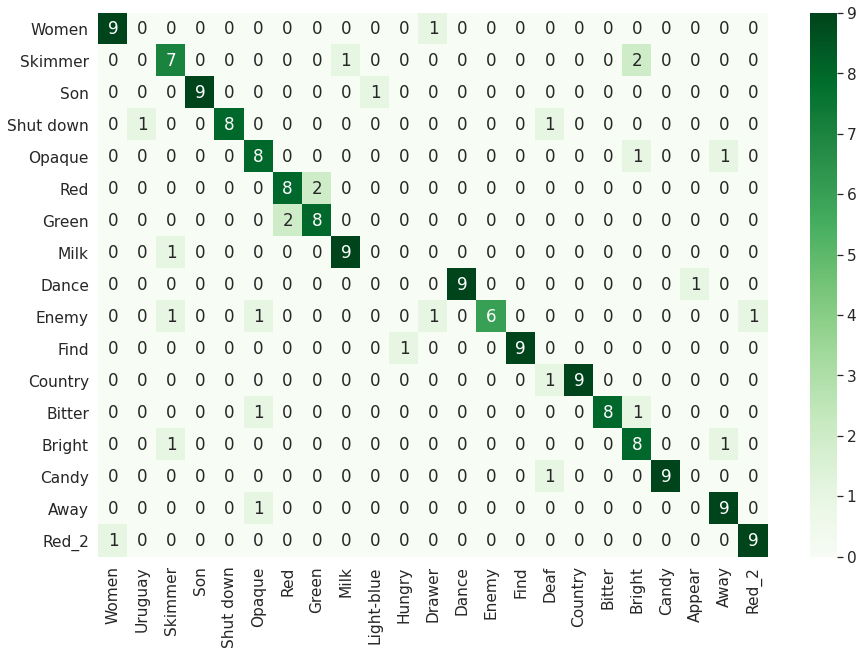

In [ ]:
# draw the confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(a, index = [i for i in a_true], columns = [i for i in a_pred])
plt.figure(figsize=(15,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, cmap = 'Greens') # font size

plt.show()

In [ ]:
# save the predict result dictionary to csv
import csv
with open('predicted_directory.csv', 'w') as f:
    for w_class in res.keys():
      for word in res[w_class]:
        f.write("%s,%s,%s\n"%(w_class,word,res[w_class][word]))
        print(w_class, " ", word, " ", res[w_class][word])

Yogurt   Yogurt   10
Women   Women   9
Women   Drawer   1
Where   Where   10
Trap   Trap   10
Uruguay   Uruguay   10
Yellow   Yellow   10
Water   Water   10
Thanks   Thanks   10
Skimmer   Bright   2
Skimmer   Milk   1
Skimmer   Skimmer   7
Ship   Ship   10
To land   To land   10
Spaghetti   Spaghetti   10
Son   Son   9
Son   Light-blue   1
Rice   Rice   10
Run   Run   10
Sweet milk   Sweet milk   10
Shut down   Shut down   8
Shut down   Uruguay   1
Shut down   Deaf   1
Music   Music   10
Perfume   Perfume   10
Mock   Mock   10
Name   Name   10
Photo   Photo   10
Patience   Patience   10
Opaque   Opaque   8
Opaque   Bright   1
Opaque   Away   1
None   None   10
Red   Red   8
Red   Green   2
Realize   Realize   10
Green   Green   8
Green   Red   2
Man   Man   10
Milk   Milk   9
Milk   Skimmer   1
Give   Give   10
Help   Help   10
Light-blue   Light-blue   10
Hungry   Hungry   10
Learn   Learn   10
Map   Map   10
Colors   Colors   10
Food   Food   10
Drawer   Drawer   10
Dance   Dance   9